# Chatbot with Profile Schema 

## Review

We introduced the [LangGraph Memory Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We built a simple chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

It saved long-term [semantic memory](https://docs.langchain.com/oss/python/concepts/memory#semantic-memory) (facts about the user) ["in the hot path"](https://docs.langchain.com/oss/python/concepts/memory#writing-memories), as the user is chatting with it.

## Goals

Our chatbot saved memories as a string. In practice, we often want memories to have a structure. 
 
For example, memories can be a [single, continuously updated schema](https://docs.langchain.com/oss/python/concepts/memory#profile). 
 
In our case, we want this to be a single user profile.
 
We'll extend our chatbot to save semantic memories to a single [user profile](https://docs.langchain.com/oss/python/concepts/memory#profile). 

We'll also introduce a library, [Trustcall](https://github.com/hinthornw/trustcall), to update this schema with new information. 

In [1]:
import uuid
from typing import TypedDict, List, List, Optional
from langgraph.store.memory import InMemoryStore
from pydantic import BaseModel, Field, ValidationError
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig
from trustcall import create_extractor

## Defining a user profile schema

Python has many different types for [structured data](https://docs.langchain.com/oss/python/langchain/models#structured-outputs), such as TypedDict, Dictionaries, JSON, and [Pydantic](https://docs.pydantic.dev/latest/). 

Let's start by using TypedDict to define a user profile schema.

In [34]:
class UserProfile(TypedDict):
    """User profile schema with typed fields"""

    user_name: str
    interests: List[str]

## Saving a schema to the store

The  [LangGraph Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore) accepts any Python dictionary as the `value`. 

In [36]:
user_profile = UserProfile(
    user_name="Umer",
    interests=["Being lonely", "woundering"]
)
user_profile

{'user_name': 'Umer', 'interests': ['Being lonely', 'woundering']}

We use the [put](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.put) method to save the TypedDict to the store.

In [37]:
# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile"

in_memory_store.put(namespace_for_memory, key, user_profile)

We use [search](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.search) to retrieve objects from the store by namespace.

In [38]:
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Umer', 'interests': ['Being lonely', 'woundering']}, 'created_at': '2026-01-06T14:08:05.589476+00:00', 'updated_at': '2026-01-06T14:08:05.589476+00:00', 'score': None}


We can also use [get](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.get) to retrieve a specific object by namespace and key.

In [39]:
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Umer', 'interests': ['Being lonely', 'woundering']}

## Chatbot with profile schema

Now we know how to specify a schema for the memories and save it to the store.

Now, how do we actually *create* memories with this particular schema?

In our chatbot, we [want to create memories from a user chat](https://docs.langchain.com/oss/python/concepts/memory#profile). 

This is where the concept of [structured outputs](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) is useful. 

LangChain's [chat model](https://docs.langchain.com/oss/python/langchain/models) interface has a [`with_structured_output`](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) method to enforce structured output.

This is useful when we want to enforce that the output conforms to a schema, and it parses the output for us.

Let's pass the `UserProfile` schema we created to the `with_structured_output` method.

We can then invoke the chat model with a list of [messages](https://docs.langchain.com/oss/python/langchain/messages) and get a structured output that conforms to our schema.

In [40]:
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)

response = model_with_structure.invoke([HumanMessage(content="My name is umer, I live in Karachi with my family. I am single.")])

In [41]:
response

{'user_name': 'Umer',
 'interests': ['family',
  'community',
  'culture',
  'technology',
  'sports',
  'travel',
  'food']}

In [42]:
namespace_for_memory = ("memory", user_id)
store = InMemoryStore()

store.put(namespace_for_memory, "user_profile", response)

In [43]:
store

In [44]:
existing_mem = store.get(namespace_for_memory, "user_profile")
existing_mem

Item(namespace=['memory', '1'], key='user_profile', value={'user_name': 'Umer', 'interests': ['family', 'community', 'culture', 'technology', 'sports', 'travel', 'food']}, created_at='2026-01-06T14:08:30.489462+00:00', updated_at='2026-01-06T14:08:30.489462+00:00')

In [45]:
memory_dict = existing_mem.value
memory_dict

{'user_name': 'Umer',
 'interests': ['family',
  'community',
  'culture',
  'technology',
  'sports',
  'travel',
  'food']}

In [46]:
memory_dict.get('user_name', 'Unknown')

'Umer'

In [47]:
memory_dict.get('interests', [])

['family', 'community', 'culture', 'technology', 'sports', 'travel', 'food']

In [49]:
(
    f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
    f"Interests: {', '.join(memory_dict.get('interests', []))}"
)

'Name: Umer\nInterests: family, community, culture, technology, sports, travel, food'

Now, let's use this with our chatbot.

This only requires minor changes to the `write_memory` function. 

We use `model_with_structure`, as defined above, to produce a profile that matches our schema. 

In [50]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """
    You are a helpful assistant with memory that provides information about the user. 
    If you have memory for this user, use it to personalize your responses.
    Here is the memory (it may be empty): {memory}
    """

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """
    Create or update a user profile memory based on the user's chat history. 
    This will be saved for long-term memory. If there is an existing memory, simply update it. 
    Here is the existing memory (it may be empty): {memory}
"""

In [56]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config['configurable']['user_id']

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
    
    # Format the memory in the system prompt
    system_msg = [SystemMessage(content=MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory))]

    # Respond using memory as well as the chat history
    response = model.invoke(
        system_msg + state["messages"]
    )

    return { "messages": response }

In [62]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config['configurable']['user_id']

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = [SystemMessage(content=CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory))]

    # Reflect on the chat history and create a memory
    response = model_with_structure.invoke(
        system_msg + state["messages"]
    )

    # Save the memory to the store
    store.put(namespace, "user_memory", response)

In [63]:
# define graph
builder = StateGraph(MessagesState)

# add nodes
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

# add edges
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

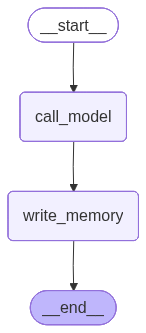

In [64]:
# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [65]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Umer and I like to bike around San Francisco and eat at bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Umer and I like to bike around San Francisco and eat at bakeries.
================================== Ai Message ==================================

Hi Umer! It's great to meet you. Biking around San Francisco sounds like a fantastic way to explore the city, and enjoying treats from bakeries is always a delight. Do you have any favorite biking routes or bakeries in San Francisco that you recommend?


Let's check the memory in the store. 

We can see that the memory is a dictionary that matches our schema.

In [66]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Umer', 'interests': ['biking', 'bakeries', 'San Francisco']}

## When can this fail?

[`with_structured_output`](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) is very useful, but what happens if we're working with a more complex schema? 

[Here's](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) an example of a more complex schema, which we'll test below. 

This is a [Pydantic](https://docs.pydantic.dev/latest/) model that describes a user's preferences for communication and trust fall.

In [67]:
class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

In [68]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

If we naively extract more complex schemas, even using high capacity model like `gpt-4o`, it is prone to failure.


## Trustcall for creating and updating profile schemas

As we can see, working with schemas can be tricky.

Complex schemas can be difficult to extract. 

In addition, updating even simple schemas can pose challenges.

Consider our above chatbot. 

We regenerated the profile schema *from scratch* each time we chose to save a new memory.

This is inefficient, potentially wasting model tokens if the schema contains a lot of information to re-generate each time.

Worse, we may loose information when regenerating the profile from scratch.

Addressing these problems is the motivation for [TrustCall](https://github.com/hinthornw/trustcall)!

This is an open-source library for updating JSON schemas developed by one [Will Fu-Hinthorn](https://github.com/hinthornw) on the LangChain team.

It's motivated by exactly these challenges while working on memory.

Let's first show simple usage of extraction with TrustCall on this list of [messages](https://docs.langchain.com/oss/python/langchain/messages).

In [69]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="I really like biking around San Francisco.")
                ]

We use `create_extractor`, passing in the model as well as our schema as a [tool](https://docs.langchain.com/oss/python/langchain/tools).

With TrustCall, can supply supply the schema in various ways. 

For example, we can pass a JSON object / Python dictionary or Pydantic model.

Under the hood, TrustCall uses [tool calling](https://docs.langchain.com/oss/python/langchain/models#tool-calling) to produce [structured output](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) from an input list of [messages](https://docs.langchain.com/oss/python/langchain/messages).

To force Trustcall to produce structured output, we can include the schema name in the `tool_choice` argument.

We can invoke the extractor with  the above conversation.

In [70]:
# schema
class UserProfile(BaseModel):
    """ User profile schema """
    user_name: str = Field(description="The name of the user")
    interests: List[str] = Field(description="Interests that the user has or list of user's interests")

In [71]:
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [72]:
trustcall_extractor = create_extractor(
    llm=model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

In [73]:
# instruction
system_message = "Extract the user's profile information from the conversation."

# Invoke the extractor
result = trustcall_extractor.invoke({
    "messages": [SystemMessage(content=system_message)] + conversation
})

When we invoke the extractor, we get a few things:

* `messages`: The list of `AIMessages` that contain the tool calls. 
* `responses`: The resulting parsed tool calls that match our schema.
* `response_metadata`: Applicable if updating existing tool calls. It says which of the responses correspond to which of the existing objects.


In [76]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_SD6MZukk29hWzamQsUVNbCKZ)
 Call ID: call_SD6MZukk29hWzamQsUVNbCKZ
  Args:
    user_name: Lance
    interests: ['biking around San Francisco']


In [80]:
result.keys()

dict_keys(['messages', 'responses', 'response_metadata', 'attempts'])

In [82]:
result

{'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 127, 'total_tokens': 144, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'id': 'chatcmpl-Cv2MKfQrwuyYlvWcRZTqKM74heJCA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b93b6-f96c-73a0-bf0d-70b6a8a17ded-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': 'Lance', 'interests': ['biking around San Francisco']}, 'id': 'call_SD6MZukk29hWzamQsUVNbCKZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 127, 'output_tokens': 17, 'total_tokens': 144, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0

In [83]:
schema = result['responses']
schema

[UserProfile(user_name='Lance', interests=['biking around San Francisco'])]

In [85]:
schema[0].model_dump()

{'user_name': 'Lance', 'interests': ['biking around San Francisco']}

In [86]:
result["response_metadata"]

[{'id': 'call_SD6MZukk29hWzamQsUVNbCKZ'}]

Let's see how we can use it to *update* the profile.

For updating, TrustCall takes a set of messages as well as the existing schema. 

The central idea is that it prompts the model to produce a [JSON Patch](https://jsonpatch.com/) to update only the relevant parts of the schema.

This is less error-prone than naively overwriting the entire schema.

It's also more efficient since the model only needs to generate the parts of the schema that have changed.

We can save the existing schema as a dict.

We can use `model_dump()` to serialize a Pydantic model instance into a dict. 

We pass it to the `"existing"` argument along with the schema name, `UserProfile`. 

In [87]:
# Update the conversation
updated_conversation = [
    HumanMessage(content="Hi, I'm Lance."), 
    AIMessage(content="Nice to meet you, Lance."), 
    HumanMessage(content="I really like biking around San Francisco."),
    AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
    HumanMessage(content="I really like to go to a bakery after biking.")
]
# Update the instruction prompt
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

In [88]:
# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke(
    {"messages": [SystemMessage(content=system_msg)] + updated_conversation},
    {"existing": {"UserProfile": schema[0].model_dump()}}
)

In [89]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_MGlu4KDJZis0LZxYP5xgHXFX)
 Call ID: call_MGlu4KDJZis0LZxYP5xgHXFX
  Args:
    user_name: Lance
    interests: ['biking', 'visiting bakeries', 'exploring San Francisco']


In [90]:
result['response_metadata']

[{'id': 'call_MGlu4KDJZis0LZxYP5xgHXFX'}]

In [91]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Lance',
 'interests': ['biking', 'visiting bakeries', 'exploring San Francisco']}

## Chatbot with profile schema updating

Now, let's bring Trustcall into our chatbot to create *and update* a memory profile.